**Importing packages that we need**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, vectorize, prange
import numba as numba
import time

**Setting up the Monte Carlo method for a NxN lattice:**

In [4]:
#function that defines that inital state for the lattice calling a random number generator
@jit(nopython=True)
def StateInitalize(N):
    #NXN number of spins
    Lattice = np.zeros((N,N))
    for i in range(N):
        for l in range(N):
            randNum = np.random.random()
            if randNum < 0.5:
                Lattice[i,l] = int(-1)
            else:
                Lattice[i,l] = int(1)
                
    return Lattice

In [35]:
#function that defines that inital state either all spins up or down
@jit()
def StateInitalizeNonRandom(N,position):
    #NXN number of spins
    if position == "up":
        temp = int(1)
    else:
        temp = int(-1)
    Lattice = np.zeros((N,N))
    for i in range(N):
        for l in range(N):
            Lattice[i,l] = temp
            randNum = np.random.random()
                
    return Lattice

In [38]:
TrialLattice = StateInitalize(4)
print(TrialLattice)
TrialLatticeUp = StateInitalizeNonRandom(4,"down")
print(TrialLatticeUp)

[[-1.  1.  1. -1.]
 [ 1.  1. -1. -1.]
 [ 1.  1. -1.  1.]
 [ 1.  1.  1.  1.]]
[[-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]


**NeigbourInteraction is a function that calculates the change in energy upon flipping one spin:**

In [7]:
@jit()
def NeigbourInteraction(line,column,InitialState,LatticeSize):
    M = LatticeSize
    DeltaE = 0
    if line == int(0):#if at the top edge of lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line+1,column]#below
    if line == int((M-1)):#if at the bottom edge lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line-1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below
    #Then check if at left or right edges or inside
    else:
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below

    DeltaE = -(Temp1 + Temp2 + Temp3 + Temp4)
    DeltaE = DeltaE*2
    if DeltaE not in [-8,-4,0,4,8]:
        print("The change in energy is not right")
    return DeltaE

**Function that calculates the Magnetization:**

In [8]:
@jit(nopython=True)
def Magnetization(Lattice):
    N,M = np.shape(Lattice)
    Magnetization = 0
    for i in range(M):#looping over lines
        for j in range(M):#looping over colums
            Magnetization += Lattice[i,j]#Adding the spin value at location i,j
    #Calculating the absolute value of Magnetization
    AbsoluteMagnetization = np.absolute(Magnetization)
    
    return Magnetization, AbsoluteMagnetization

In [9]:
#Trial of Magnetization function
LatticeA = np.array([[1,1],[-1,-1]])
Magn, AbsMagn = Magnetization(LatticeA)
print("The Magnetization is:",Magn)
print("The Absolute Magnetization is:",AbsMagn)

The Magnetization is: 0
The Absolute Magnetization is: 0


**Calculating the energy of the lattice according to the Ising model with periodic boundary conditions:**

In [10]:
@jit()
def LatticeEnergyIsing(InitialState,LatticeSize):
    N,M = np.shape(InitialState)#Lattice size
    Energy = 0
    for i in range(M):#loop over lines
        for j in range(M):#loop over columns
            #Only checking every other site so that one doesn't double count
            DoMeasurement = (np.mod(i,2)+np.mod(j,2) == 0) or (np.mod(i,2)+np.mod(j,2) == 2)
            #print(Acceptance)
            if DoMeasurement:
                if (i == 0 and j == 0):#if at the top and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == 0 and j == (M-1)):#if at the top and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == (M-1) and j == 0):#if at the bottom and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == (M-1) and j == (M-1)):#if at the bottom and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == 0:#if only at top edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == (M-1):#if only at bottom edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == 0:#if only at left edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == (M-1):#if only at right edge
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                else:#if somewhere in the middle
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                
    return Energy

In [39]:
#Trial of energy
B = np.array([[-1,-1],[1,1]])
print(B)
EnergyTrial = LatticeEnergyIsing(B,2)
print("The energy according to Ising Model:", EnergyTrial)
TrialLatticeUp = StateInitalizeNonRandom(80,"down")
EnergyTrial2 = LatticeEnergyIsing(TrialLatticeUp,80)
print("For all spins down the energy is:", EnergyTrial2)
#Trial of change in energy
DeltaE = NeigbourInteraction(1,0,B,2)
print("The change in energy upon flipping spin at [0,1]",DeltaE)

[[-1 -1]
 [ 1  1]]
The energy according to Ising Model: 0
For all spins down the energy is: -12800.0
The change in energy upon flipping spin at [0,1] 0


**Metropolis part:**

In [12]:
@jit()
def Metropolis(DeltaEnergy,Temperature):
    if DeltaEnergy not in [-8,-4,0,4,8]:
        print("The change in Energy does not agree with the Ising model")
    Accept = False
    Exp1 = np.exp(-(1/Temperature)*(-8))
    Exp2 = np.exp(-(1/Temperature)*(-4))
    Exp3 = 1
    Exp4 = np.exp(-(1/Temperature)*(4))
    Exp5 = np.exp(-(1/Temperature)*(8))
    if DeltaEnergy < 0:
        Accept = True
    else:
        randNum = np.random.random()
        if DeltaEnergy == -8:
            w = Exp1
        elif DeltaEnergy == -4:
            w = Exp2
        elif DeltaEnergy == 0:
            w = Exp3
        elif DeltaEnergy == 4:
            w = Exp4
        else:
            w = Exp5
        #Checking w agains the exponent and accepting if r <= w
        if randNum <= w:
            Accept = True
        else:
            Accept = False
            
    return Accept

**The Monte Carlo calculation itself:**

In [13]:
@jit(nopython=True)
def MonteCarloIsing(InitialState1,NumOfCycles,LatticeSize,Temperature,SkipCycles):
    EnergyVector = np.zeros(NumOfCycles-(SkipCycles+1))
    MagnetizationVector = np.zeros(NumOfCycles-(SkipCycles+1))
    MagnetizationVectorAbs = np.zeros(NumOfCycles-(SkipCycles+1))
    M = LatticeSize
    NSpins = M*M#Number of spins
    InitialState = InitialState1#Setting a lattice for overwriting
    #Calculating the initial energy
    Energy = LatticeEnergyIsing(InitialState,M)
    #print(Energy)
    MC = NumOfCycles
    #SkipCycles = 80001#Number of cycles to skip for the system to reach its most likely state
    CounterAcceptance = 0#Counter to see how many moves are accepted
    Energy = LatticeEnergyIsing(InitialState,M)
    EnergyValue = 0
    EnergyValueSquared = 0
    MagnValue = 0
    MagnValueSquared = 0
    MagnValueAbs = 0
    norm = 1/MC
    T = Temperature
    counter = 0
    for i in range(MC):#Looping over the number of MC cycles
        #picking a random coordinate in the lattice
        line = np.random.randint(M)
        column = np.random.randint(M)
        #print(randNum,line,column)
        #flipping the spin at that position
        TempState = InitialState.copy()
        #print(InitialState[line,column])
        #print(InitialState)
        if InitialState[line,column] == 1:
            TempState[line,column] = int(-1)
            tempValue = int(-1)#setting temp value to the assign to the system if move is accepted
        else:
            TempState[line,column] = int(1)
            tempValue = int(1)#setting temp value to the assign to the system if move is accepted
        #finding the difference in energy - using periodic boundary conditions
        DeltaE = NeigbourInteraction(line,column,TempState,M)
        Acceptance = Metropolis(DeltaE,T)
        #Metropolis part
        if Acceptance:
            InitialState[line,column] = tempValue#Change the spin at the random location
            Energy += DeltaE#Changing the energy value
            CounterAcceptance += 1  
        #Appending Energy and other relevant variables for calculations
        if i > SkipCycles:#Accounting for time that it takes to reach the most likely state
            EnergyVector[counter] = Energy
            EnergyValue += Energy
            EnergyValueSquared += Energy**2
            #Magnetization
            MagnetiZ, MagnetiZAbs = Magnetization(InitialState)
            MagnetizationVector[counter] = MagnetiZ
            MagnetizationVectorAbs[counter] = MagnetiZAbs
            MagnValue += MagnetiZ
            MagnValueSquared += MagnetiZ**2
            MagnValueAbs += MagnetiZAbs
            counter += 1
        #End of MC loop

    MC = MC - SkipCycles#Accounting for the number of cycles that were skipped
    #Calculating average energy per particle
    #TotalEnergy = sum(EnergyVector)
    AverageEnergy = EnergyValue/MC
    AverageEnergySquared = EnergyValueSquared/MC
    #Energy per spin
    EnergyPerParticle = AverageEnergy/NSpins
    #Variance in Energy
    EnergyVariancePerSpin = (AverageEnergySquared - AverageEnergy**2)/NSpins
    #Specific Heat - SPURNING hvað ég að nota fyrir Boltzmanns fasta
    k = 1
    SpecificHeat = (1/(k*(T**2)))*EnergyVariancePerSpin
    #Magnetization
    AverageMagnetization = MagnValue/MC
    AverageMagnetizationPerPar = AverageMagnetization/NSpins
    AverageMagnetizationSquared = MagnValueSquared/MC
    AverageMagnetizationAbs = MagnValueAbs/MC
    AverageMagnetizationAbsPerSpin = AverageMagnetizationAbs/NSpins
    #Variance in Magnetization
    MagnetizationVariancePerSpin = (AverageMagnetizationSquared - AverageMagnetizationAbs**2)/(NSpins)
    #Susceptibility
    Susceptibility = (1/(k*T))*MagnetizationVariancePerSpin

    return CounterAcceptance, EnergyVector, MagnetizationVector, MagnetizationVectorAbs, EnergyPerParticle, AverageMagnetizationPerPar, AverageMagnetizationAbsPerSpin, SpecificHeat, Susceptibility

**Trying the algo for a 2x2 case:**

In [14]:
A = StateInitalize(2)
TempSmall = np.arange(0.1,5.1,0.4)
EnergySmallCase = np.zeros(len(TempSmall))
SpecHeatSmallCase = np.zeros(len(TempSmall))
MeanMagnAbsSmallCase = np.zeros(len(TempSmall))
SusceptibilitySmallCase = np.zeros(len(TempSmall))
start = time.time()
counter = 0
for T1 in TempSmall:
    AcceptedMoves, EnergyAll, MagnAll, MagnAllAbs,EnergyPerPart, AverageMagn, AverageMagnAbs, SpecificHeat, Susceptibility = MonteCarloIsing(A,1000000,2,T1,0)
    EnergySmallCase[counter] = EnergyPerPart
    SpecHeatSmallCase[counter] = SpecificHeat
    MeanMagnAbsSmallCase[counter] = AverageMagnAbs
    SusceptibilitySmallCase[counter] = Susceptibility
    counter += 1
    
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMoves)
print("Energy per particle:",EnergyPerPart)
print("The Average magnetization per spin is:",AverageMagn)
print("The Average absolute magnetization per spin is",AverageMagnAbs)
print("The Specific Heat is:",SpecificHeat)
print("The Susceptibility is:",Susceptibility)

The measurement took, in seconds: 5.805278539657593
Number of Accepted moves: 564405
Energy per particle: -0.870582
The Average magnetization per spin is: 0.000952
The Average absolute magnetization per spin is 0.629386
The Specific Heat is: 0.18706788526047474
The Susceptibility is: 0.11831694939102043


## Analytical results for 2x2 case:

**We now look at analytical results for a 2x2 case of spins:**

In [15]:
#All the relevant functions for the 2x2 case
def EnergyExp(T):
    Beta = 1/T
    temp = -((8*np.sinh(8*Beta))/(np.cosh(8*Beta) + 3))
    return temp/4

def Z(T):
    Beta = 1/T
    return 2*np.exp(8*Beta) + 12 + 2*np.exp(-8*Beta)

def SpecificHeatSmall(T):##Eitthvað vitlaust hér eða hvað??
    Beta = 1/T
    teljari = 64*(1 + 3*np.cosh(8*Beta))
    nefnari = (T**2)*((np.cosh(8*Beta) + 3)**2)
    return teljari/nefnari/4

def AveragAbsMagnSmall(T):
    Beta = 1/T
    temp = (8*np.exp(8*Beta) + 16)/Z(T)
    return temp/4

def SusceptibilitySmall(T):
    Beta = 1/T
    firstTerm = (32/Z(T))*(1 + np.exp(8*Beta))
    secondTerm = (64/Z(T)**2)*((2 + np.exp(8*Beta)))**2
    return Beta*(firstTerm - secondTerm)/4

**Let's plot: (Fæ rétta hegðun en eins og einhverjur númerískar faktorar séu off)**

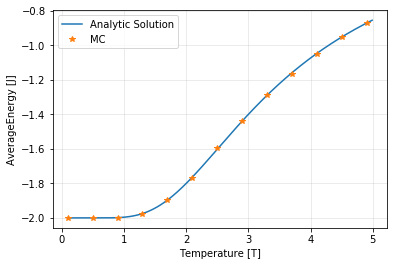

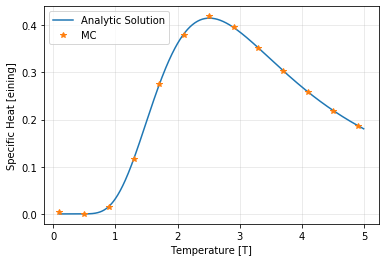

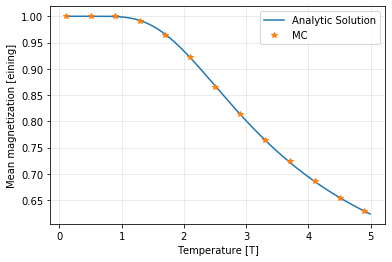

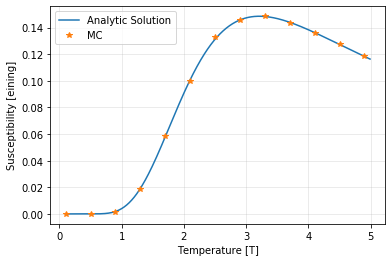

In [16]:
fig0,ax0 = plt.subplots()
T = np.arange(0.1,5,0.01)
AvergeEnergySmall = EnergyExp(T)
SpecHeatSmall = SpecificHeatSmall(T)
AverageAbsSmall = AveragAbsMagnSmall(T)
SucsSmall = SusceptibilitySmall(T)
#Average energy
ax0.plot(T,AvergeEnergySmall,label="Analytic Solution")
ax0.plot(TempSmall,EnergySmallCase,'*',label="MC")
ax0.grid(alpha=0.3)
ax0.set_ylabel("AverageEnergy [J]")
ax0.set_xlabel("Temperature [T]")
ax0.legend()
#Specific Heat
fig0_1,ax0_1 = plt.subplots()
ax0_1.plot(T,SpecHeatSmall,label="Analytic Solution")
ax0_1.plot(TempSmall,SpecHeatSmallCase,'*',label="MC")
ax0_1.grid(alpha=0.3)
ax0_1.set_ylabel("Specific Heat [eining]")
ax0_1.set_xlabel("Temperature [T]")
ax0_1.legend()
#Mean magnetization - Skrýtið gildi fyrir analytical!!
fig0_2,ax0_2 = plt.subplots()
ax0_2.plot(T,AverageAbsSmall,label="Analytic Solution")
ax0_2.plot(TempSmall,MeanMagnAbsSmallCase,'*',label="MC")
ax0_2.grid(alpha=0.3)
ax0_2.set_ylabel("Mean magnetization [eining]")
ax0_2.set_xlabel("Temperature [T]")
ax0_2.legend()
#Susceptibility - Per spin!
fig0_3,ax0_3 = plt.subplots()
ax0_3.plot(T,SucsSmall,label="Analytic Solution")
ax0_3.plot(TempSmall,SusceptibilitySmallCase,'*',label="MC")
ax0_3.grid(alpha=0.3)
ax0_3.set_ylabel("Susceptibility [eining]")
ax0_3.set_xlabel("Temperature [T]")
ax0_3.legend()

## Parallelized Monte Carlo:

**Eitthvað sem fer vel úr skorðum við útreikninga!!! Möguleg lausn að kalla á gamla fallið sem gerir alla útreikninga og annað yfirfall sem sér bara um að skipta á milli þráða samkvæmt hitastigi**

In [17]:
@jit(nopython=True,parallel=True)
def MonteCarloIsingParallel2(State,NumOfCycles,L,Temperature,Time,SkipCycles):
    #Calling the original MCIsing with Temperature Parallized
    T = Temperature
    CounterAccept = np.zeros(len(T))
    EnergyPerPart = np.zeros(len(T))
    AverageMagnPerPart = np.zeros(len(T))
    AverageMagnPerPartAbs = np.zeros(len(T))
    SpecificHeat = np.zeros(len(T))
    Susceptibility = np.zeros(len(T))
    TempSkip = SkipCycles
    for i in prange(len(T)):
        np.random.seed(Time*(i+1))#Seeding differently for each thread if they start at the same time
        #Calling the original MC Ising
        TempState = State.copy()
        CountAcc, EnergyVec, AvMagnVec, AvMagnAbsVec, EnPerPa, AvMagnPePa, AvMagnPePaAbs, SpeHeat, Susc = MonteCarloIsing(TempState,NumOfCycles,L,T[i],TempSkip)
        CounterAccept[i] = CountAcc
        EnergyPerPart[i] = EnPerPa
        AverageMagnPerPart[i] = AvMagnPePa
        AverageMagnPerPartAbs[i] = AvMagnPePaAbs
        SpecificHeat[i] = SpeHeat
        Susceptibility[i] = Susc
        

    
        
    return CounterAccept, EnergyPerPart, AverageMagnPerPart, AverageMagnPerPartAbs, SpecificHeat, Susceptibility

**Writing to file:**

In [18]:
def WriteToFile(filename,NumOfCycles,SkipCycles,L,EnergyPerPart,SpecificHeat,AverageMagnPerPartAbs,Susceptibility,CounterAccept,T):
    #writing the the relevant quantities to file
    f = open(filename,"w+")
    f.write("Number of Monte Carlo Cycles: \t" + str(int(NumOfCycles)) + "\n")
    f.write("Number of MC cycles skipped before measurements: \t" + str(int(SkipCycles)) + "\n" )
    f.write("Lattice size, L = \t" + str(int(L)) + "\n")
    f.write("Number of different Temperature Measurements: \t" + str(int(len(T))) + "\n")
    f.write("Temperature \t EnergyPerParticle \t Heat Capacity Per Part \t Absolute Mean Magnetization \t Susceptibility \t No of accepted steps \n")
    for i in range(len(T)):
        f.write(str(T[i]) + "\t" + str(EnergyPerPart[i]) + "\t" + str(SpecificHeat[i]) + "\t" + str(AverageMagnPerPartAbs[i]) + "\t" + str(Susceptibility[i]) + "\t" + str(CounterAccept[i]) + "\n")
        
    f.close()

In [19]:
f = open("TrialFile.txt","w+")
f.write("Number of Monte Carlo Cycles: \t 100000\n")
f.write("Number of MC cycles skipped before measurements: \t 10000 \n")
f.write("Lattice size, L = \t 10 \n")
f.write("Number of different Temperature Measurements:")

for i in range(10):
    f.write("Hello \n")
        
f.close()

In [20]:
#Trial of New Parallized MC
Time = time.time()
L = 2
StateP = StateInitalize(L)
TempRange = np.arange(0.2,5,0.1)
#TempRange = np.array([1])
SkipCycl = 0
MCCycles = int(1e6)
filename = "TrialWriting.txt"
print(TempRange)
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP = MonteCarloIsingParallel2(StateP,MCCycles,L,TempRange,Time,0)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMovesP)
print("Energy per particle:",EnergyPerPartP)
print("The Average magnetization per spin is:",AverageMagnP)
print("The Average absolute magnetization per spin is",AverageMagnAbsP)
print("The Specific Heat is:",SpecificHeatP)
print("The Susceptibility is:",SusceptibilityP)

WriteToFile(filename,MCCycles,SkipCycl,L,EnergyPerPartP,SpecificHeatP,AverageMagnAbsP,SusceptibilityP,AcceptedMovesP,TempRange)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
The measurement took, in seconds: 8.494343519210815
Number of Accepted moves: [4.00000e+00 6.00000e+00 8.00000e+00 2.00000e+01 1.60000e+01 1.16000e+02
 2.12000e+02 9.52000e+02 2.20000e+03 4.25600e+03 7.50600e+03 1.21660e+04
 1.89540e+04 2.83720e+04 3.90940e+04 5.06180e+04 6.64020e+04 8.05560e+04
 9.90520e+04 1.17556e+05 1.39086e+05 1.57110e+05 1.79540e+05 1.99302e+05
 2.17774e+05 2.38584e+05 2.59294e+05 2.79890e+05 3.00492e+05 3.19600e+05
 3.37008e+05 3.55902e+05 3.73008e+05 3.90503e+05 4.04866e+05 4.21544e+05
 4.36188e+05 4.51364e+05 4.63912e+05 4.77174e+05 4.88860e+05 5.02375e+05
 5.11920e+05 5.24253e+05 5.37065e+05 5.45605e+05 5.55745e+05 5.64464e+05]
Energy per particle: [-1.999992 -1.99999  -1.999986 -1.999954 -1.99997  -1.999746 -1.99961
 -1.998082 -1.995566 -1.99132  -1.98504  -1.975536

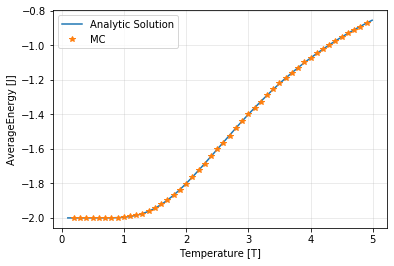

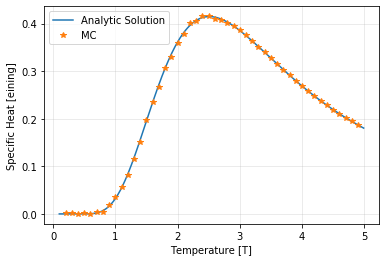

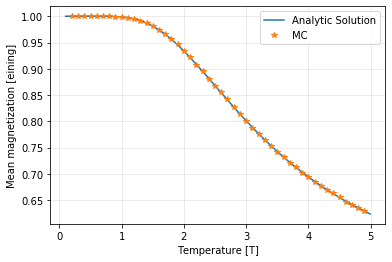

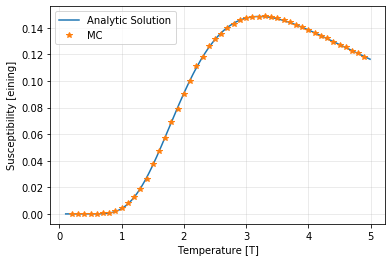

In [21]:
#Plotting the trial parallized
fig1_0,ax1_0 = plt.subplots()
T = np.arange(0.1,5,0.01)
AvergeEnergySmall = EnergyExp(T)
SpecHeatSmall = SpecificHeatSmall(T)
AverageAbsSmall = AveragAbsMagnSmall(T)
SucsSmall = SusceptibilitySmall(T)
#Average energy
ax1_0.plot(T,AvergeEnergySmall,label="Analytic Solution")
ax1_0.plot(TempRange,EnergyPerPartP,'*',label="MC")
ax1_0.grid(alpha=0.3)
ax1_0.set_ylabel("AverageEnergy [J]")
ax1_0.set_xlabel("Temperature [T]")
ax1_0.legend()
#Specific Heat
fig1_1,ax1_1 = plt.subplots()
ax1_1.plot(T,SpecHeatSmall,label="Analytic Solution")
ax1_1.plot(TempRange,SpecificHeatP,'*',label="MC")
ax1_1.grid(alpha=0.3)
ax1_1.set_ylabel("Specific Heat [eining]")
ax1_1.set_xlabel("Temperature [T]")
ax1_1.legend()
#Mean magnetization - Skrýtið gildi fyrir analytical!!
fig1_2,ax1_2 = plt.subplots()
ax1_2.plot(T,AverageAbsSmall,label="Analytic Solution")
ax1_2.plot(TempRange,AverageMagnAbsP,'*',label="MC")
ax1_2.grid(alpha=0.3)
ax1_2.set_ylabel("Mean magnetization [eining]")
ax1_2.set_xlabel("Temperature [T]")
ax1_2.legend()
#Susceptibility - Per spin!
fig1_3,ax1_3 = plt.subplots()
ax1_3.plot(T,SucsSmall,label="Analytic Solution")
ax1_3.plot(TempRange,SusceptibilityP,'*',label="MC")
ax1_3.grid(alpha=0.3)
ax1_3.set_ylabel("Susceptibility [eining]")
ax1_3.set_xlabel("Temperature [T]")
ax1_3.legend()

**Plotting the energy as a function of MC steps:**

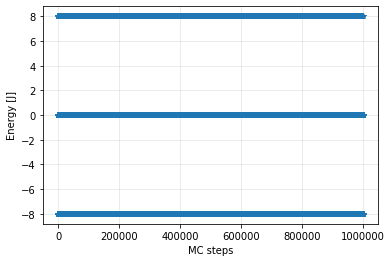

In [22]:
fig, ax = plt.subplots()
Steps = np.arange(0,1000000-(SkipCycl+1))
ax.plot(Steps,EnergyAll,'*')
ax.set_xlabel("MC steps")
ax.set_ylabel("Energy [J]")
ax.grid(alpha=0.3)
plt.show()

**Trial for bigger lattice:**

In [32]:
L = 80
A2 = StateInitalize(L)
T2 = 1
SkippingCycles = 0
MCCycles = int(3e7)
start = time.time()
AcceptedMoves2, EnergyAll2, MagnAll2, MagnallAbs2, EnergyPerPart2, AverageMagn2, AverageMagnAbs2,SpecificHeat2, Susceptibility2 = MonteCarloIsing(A2,MCCycles,L,T2,SkippingCycles)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMoves2)
print("Energy per particle:",EnergyPerPart2)
print("The Average magnetization is:",AverageMagn2)
print("The Averaga absolute magnetization is:",AverageMagnAbs2)
print("The Specific Heat is:",SpecificHeat2)
print("The Susceptibility is:", Susceptibility2)

The measurement took, in seconds: 286.43663120269775
Number of Accepted moves: 417451
Energy per particle: -2.3392693890625
The Average magnetization is: -0.33631195612500003
The Averaga absolute magnetization is: 0.3495298958333333
The Specific Heat is: 221.2992947600968
The Susceptibility is: 103.0689583025554


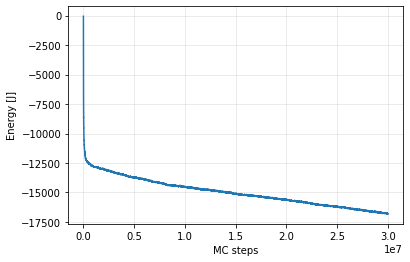

In [33]:
fig2, ax2 = plt.subplots()
Steps2 = np.arange(0,MCCycles-SkippingCycles-1)
ax2.plot(Steps2,EnergyAll2)
ax2.set_xlabel("MC steps")
ax2.set_ylabel("Energy [J]")
ax2.grid(alpha=0.3)
plt.show()

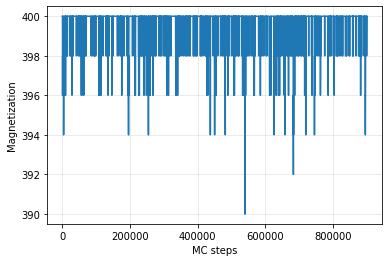

In [640]:
fig2_2, ax2_2 = plt.subplots()
Steps2 = np.arange(0,1000000-SkippingCycles-1)
#ax2_2.plot(Steps2,MagnAll2)
ax2_2.plot(Steps2,MagnallAbs2)
ax2_2.set_xlabel("MC steps")
ax2_2.set_ylabel("Magnetization")
ax2_2.grid(alpha=0.3)
plt.show()

**We see that the system has reached its most likely state after at least 80000 iterations, but often quite lower. Thus we start to take measurements after 80000 iterations for analysis. Getur verið mun hærra!!**

**Let's do measurements for several different Temperature:**

[0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1   1.2
 1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.005 2.01  2.015 2.02
 2.025 2.03  2.035 2.04  2.045 2.05  2.055 2.06  2.065 2.07  2.075 2.08
 2.085 2.09  2.095 2.1   2.105 2.11  2.115 2.12  2.125 2.13  2.135 2.14
 2.145 2.15  2.155 2.16  2.165 2.17  2.175 2.18  2.185 2.19  2.195 2.2
 2.205 2.21  2.215 2.22  2.225 2.23  2.235 2.24  2.245 2.25  2.255 2.26
 2.265 2.27  2.275 2.28  2.285 2.29  2.295 2.35  2.45  2.55  2.65  2.75
 2.85  2.95  3.05  3.15  3.25  3.35  3.45  3.55  3.65  3.75  3.85  3.95 ]
took in seconds:  771.2021954059601


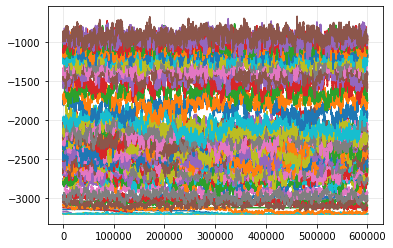

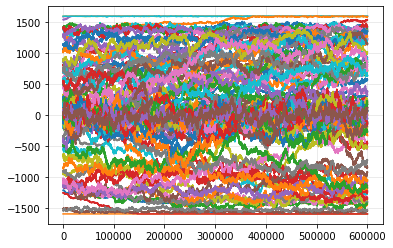

In [455]:
#T = [0.1,0.3,0.5,0.7,0.9,1,1.3,1.5,1.7,1.9,2,2.3,2.5,2.7,2.9,3]
a = np.arange(0.1,2,0.1)
b = np.arange(2.0,2.3,0.005)
c = np.concatenate((a,b),axis=0)
d = np.arange(2.35,4,0.1)
T = np.concatenate((c,d),axis=0)
#T = np.arange(2.0,2.3,0.005)
print(T)
SkipSteps = 400000
MC_Cycles = int(1e6)
Steps3 = np.arange(0,MC_Cycles-(SkipSteps+1))
AcceptedMoves = np.zeros(len(T))
EnergyPerParticle = np.zeros(len(T))
MagnetizationPerParticle = np.zeros(len(T))
Susceptibility = np.zeros(len(T))
SpecificHeat = np.zeros(len(T))
fig3, ax3 = plt.subplots()
fig3_1,ax3_1 = plt.subplots()
counter = 0
L = 40#Lattice size
start = time.time()
for i in range(len(T)):
    Temp = T[i]
    A3 = StateInitalize(L)
    AcceptedMoves2, EnergyAll2, MagnAll2, MagnAllAbs2, EnergyPerPart2, AverageMagn2, AverageMagnAbs2, SpecificHeat2, Susceptibility2 = MonteCarloIsing(A3,MC_Cycles,L,Temp,SkipSteps)
    EnergyPerParticle[counter] = EnergyPerPart2
    SpecificHeat[counter] = SpecificHeat2
    MagnetizationPerParticle[counter] = AverageMagnAbs2
    Susceptibility[counter] = Susceptibility2
    counter += 1
    ax3.plot(Steps3,EnergyAll2)
    ax3_1.plot(Steps3,MagnAll2)
    
end = time.time()
print("took in seconds: ",end-start)
ax3.grid(alpha=0.3)
ax3_1.grid(alpha=0.3)
plt.show()

**Energy per particle as a function of temperature:**

Gæti verið að Setupið sé ekki búið að converga???

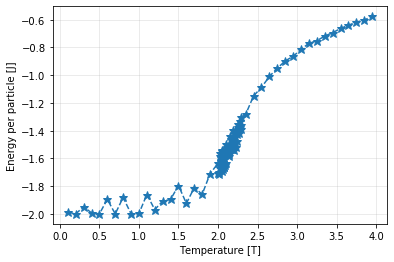

In [456]:
#Plotting energy as a function of particle
fig4,ax4 = plt.subplots()
ax4.plot(T,EnergyPerParticle,'*--',ms=9)
ax4.set_ylabel("Energy per particle [J]")
ax4.set_xlabel("Temperature [T]")
ax4.grid(alpha=0.3)
plt.show()

**Specific heat as a function of temperature:**

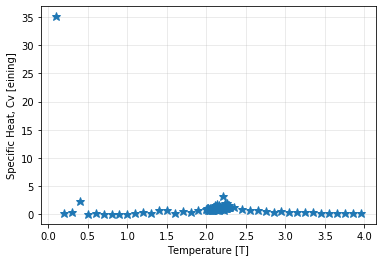

In [457]:
#Plotting specific heat as a function of Temperature - Eitthvað mjög flippað í gangi hér !!
fig5,ax5 = plt.subplots()
ax5.plot(T,SpecificHeat,'*',ms=9)
ax5.set_ylabel("Specific Heat, Cv [eining]")
ax5.set_xlabel("Temperature [T]")
ax5.grid(alpha=0.3)
plt.show()

**Average Magnetization as a function of particle:**

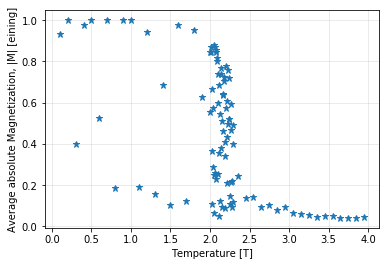

In [458]:
#Plotting average Magnetization as a function of temperature
fig6,ax6 = plt.subplots()
ax6.plot(T,MagnetizationPerParticle,'*',ms=7)
ax6.set_ylabel("Average absolute Magnetization, |M| [eining]")
ax6.set_xlabel("Temperature [T]")
ax6.grid(alpha=0.3)
plt.show()

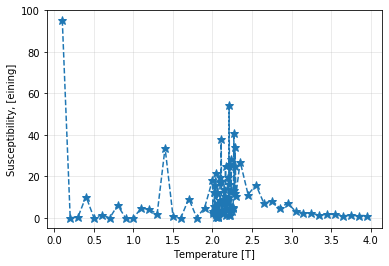

In [462]:
#Plotting average Magnetization as a function of temperature
fig6,ax6 = plt.subplots()
ax6.plot(T,Susceptibility,'*--',ms=9)
ax6.set_ylabel("Susceptibility, [eining]")
ax6.set_xlabel("Temperature [T]")
ax6.grid(alpha=0.3)
plt.show()

**Accurate measurements around $T_C$:** Eitthvað mjög flippað í gangi, held með parallelization!!!!

In [48]:
#Trial of Parallized MC
#Assigning Temperature
a = np.arange(0.1,2,0.1)
b = np.arange(2.0,2.3,0.005)
c = np.concatenate((a,b),axis=0)
d = np.arange(2.35,4,0.1)
TempRange = np.concatenate((c,d),axis=0)
print(TempRange)
#Creating Lattice
L = 40
MCCycles = int(3e6)
SkipCycles = int(0.5e6)
StateP = StateInitalize(L)
#TempRange = np.arange(0.2,3.5,0.1)
#print(TempRange)
Time = time.time()
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP = MonteCarloIsingParallel2(StateP,2000000,L,TempRange,Time,SkipCycles)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMovesP)
print("Energy per particle:",EnergyPerPartP)
print("The Average magnetization per spin is:",AverageMagnP)
print("The Average absolute magnetization per spin is",AverageMagnAbsP)
print("The Specific Heat is:",SpecificHeatP)
print("The Susceptibility is:",SusceptibilityP)

[0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1   1.2
 1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.005 2.01  2.015 2.02
 2.025 2.03  2.035 2.04  2.045 2.05  2.055 2.06  2.065 2.07  2.075 2.08
 2.085 2.09  2.095 2.1   2.105 2.11  2.115 2.12  2.125 2.13  2.135 2.14
 2.145 2.15  2.155 2.16  2.165 2.17  2.175 2.18  2.185 2.19  2.195 2.2
 2.205 2.21  2.215 2.22  2.225 2.23  2.235 2.24  2.245 2.25  2.255 2.26
 2.265 2.27  2.275 2.28  2.285 2.29  2.295 2.35  2.45  2.55  2.65  2.75
 2.85  2.95  3.05  3.15  3.25  3.35  3.45  3.55  3.65  3.75  3.85  3.95 ]
The measurement took, in seconds: 809.1681473255157
Number of Accepted moves: [   8950.    7838.   15852.   14888.   11406.   12846.   12394.   25827.
   14153.   46704.   24551.   50874.   85427.   65496.   70722.  113911.
  119321.  115050.  145899.  193856.  197409.  199869.  196265.  242943.
  217794.  219676.  215108.  268556.  234482.  265945.  234424.  275873.
  275407.  256856.  250036.  292126.  252569.  252231.

**Plotting the relevant Parameters:**

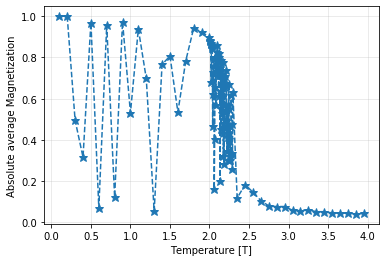

In [49]:
fig7, ax7 = plt.subplots()
ax7.plot(TempRange,AverageMagnAbsP,'*--',ms=9)
ax7.set_ylabel("Absolute average Magnetization")
ax7.set_xlabel("Temperature [T]")
ax7.grid(alpha=0.3)

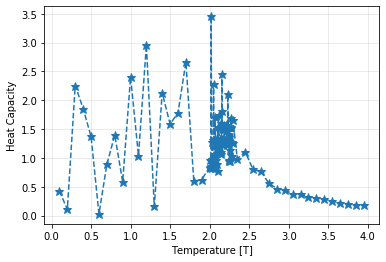

In [50]:
#Heat capacity
fig8, ax8 = plt.subplots()
ax8.plot(TempRange,SpecificHeatP,'*--',ms=9)
ax8.set_ylabel("Heat Capacity")
ax8.set_xlabel("Temperature [T]")
ax8.grid(alpha=0.3)

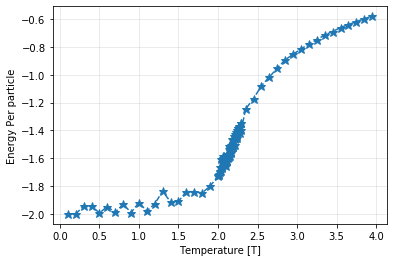

In [51]:
#Energy per Particle
fig9, ax9 = plt.subplots()
ax9.plot(TempRange,EnergyPerPartP,'*--',ms=9)
ax9.set_ylabel("Energy Per particle")
ax9.set_xlabel("Temperature [T]")
ax9.grid(alpha=0.3)

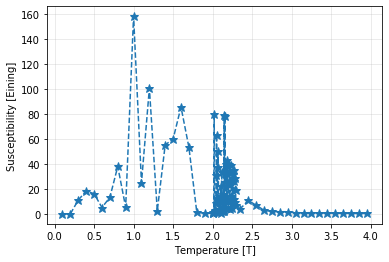

In [52]:
#Susceptibility
fig10, ax10 = plt.subplots()
ax10.plot(TempRange,SusceptibilityP,'*--',ms=9)
ax10.set_ylabel("Susceptibility [Eining]")
ax10.set_xlabel("Temperature [T]")
ax10.grid(alpha=0.3)

## Functions not used:

In [ ]:
@jit(nopython=True,parallel=True)
def MonteCarloIsingParallel(InitialState1,NumOfCycles,LatticeSize,Temperature,Time):
    EnergyVector = np.zeros(NumOfCycles-80001)
    MagnetizationVector = np.zeros(NumOfCycles-80001)
    MagnetizationVectorAbs = np.zeros(NumOfCycles-80001)
    M = LatticeSize
    NSpins = M*M#Number of spins
    InitialState = InitialState1#Setting a lattice for overwriting
    #Calculating the initial energy
    Energy = LatticeEnergyIsing(EnergyMatrix,M)
    #print(Energy)
    MC = NumOfCycles
    SkipCycles = 80001#Number of cycles to skip for the system to reach its most likely state
    CounterAcceptance = np.zeros(len(Temperature))#Counter to see how many moves are accepted
    EnergyValue = np.zeros(len(Temperature))
    EnergyValueSquared = np.zeros(len(Temperature))
    MagnValue = np.zeros(len(Temperature))
    MagnValueSquared = np.zeros(len(Temperature))
    MagnValueAbs = np.zeros(len(Temperature))
    norm = 1/MC
    #Parallelization
    counter = np.zeros(len(Temperature))
    T = Temperature
    
    InitialStates = np.array([[np.zeros((L,L))]])#Assigning array of the same state for each vector to work on
    InitialStates[:] = InitialState
    for j in prange(len(Temperature)):
        np.random.seed(Time*(j+1))#Seeding differently for each thread if they start at the same time
        tempTemp = T[j]
        for i in range(MC):#Looping over the number of MC cycles
            #picking a random coordinate in the lattice
            randNum = np.random.randint(M*M)
            line = int(np.floor(randNum/M))#finding the relavant line in the lattice
            column = int(randNum - M*line)#finding the relavant column in the lattice
            #print(randNum,line,column)
            #flipping the spin at that position
            TempState = InitialStates[j][0].copy()
            #print(InitialState[line,column])
            #print(InitialState)
            if InitialState[line,column] == 1:
                TempState[line,column] = int(-1)
                tempValue = int(-1)#setting temp value to the assign to the system if move is accepted
            else:
                TempState[line,column] = int(1)
                tempValue = int(1)#setting temp value to the assign to the system if move is accepted
            #finding the difference in energy - using periodic boundary conditions
            DeltaE = NeigbourInteraction(line,column,TempState,M)
            if DeltaE not in [-8,-4,0,4,8]:
                print("vúpps")
            Acceptance = Metropolis(DeltaE,tempTemp)
            #Metropolis part
            if Acceptance:
                InitialStates[j][0][line,column] = tempValue
                CounterAcceptance[j] += 1  
            #Appending Energy and other relevant variables for calculations
            Energy = LatticeEnergyIsing(InitialStates[j][0],M)#Þarf að taka alltaf gildin á orkunni!!!
            if i > 80000:#Accounting for time that it takes to reach the most likely state
                #EnergyVector[counter] = Energy
                EnergyValue[j] += Energy
                EnergyValueSquared[j] += Energy**2
                #Magnetization
                MagnetiZ = Magnetization(InitialStates[j][0])
                #MagnetizationVector[counter] = MagnetiZ
                MagnValue[j] += MagnetiZ
                MagnValueSquared[j] += MagnetiZ**2
                MagnValueAbs[j] += np.absolute(MagnetiZ)
                counter[j] += 1
            #End of MC loop

    #print(InitialState)
    MC = MC - SkipCycles
    #print(Energy)
    #FinalEnergy = LatticeEnergyIsing(InitialState,M)
    #Calculating average energy per particle
    #TotalEnergy = sum(EnergyVector)
    AverageEnergy = EnergyValue/MC
    AverageEnergySquared = EnergyValueSquared/MC
    #Energy per spin
    EnergyPerParticle = AverageEnergy/NSpins
    #Magnetization
    AverageMagnetization = MagnValue/MC
    AverageMagnetizationPerPar = AverageMagnetization/NSpins
    AverageMagnetizationSquared = MagnValueSquared/MC
    AverageMagnetizationAbs = MagnValueAbs/MC
    AverageMagnetizationAbsPerSpin = AverageMagnetizationAbs/NSpins
    #Calculating the rest
    EnergyVariancePerSpin = np.zeros(len(T))
    #SpecificHeat = np.zeros(len(T))
    MagnetizationVariancePerSpin = np.zeros(len(T))
    Susceptibility = np.zeros(len(T))
    #for i in range(len(T)):#Eitthvað flipp í gangi hér!!
    #Variance in Energy
    EnergyVariancePerSpin = (AverageEnergySquared - AverageEnergy**2)/NSpins
    #Variance in Magnetization
    MagnetizationVariancePerSpin = (AverageMagnetizationSquared - AverageMagnetization**2)/(NSpins)
    #Specific Heat - SPURNING hvað ég að nota fyrir Boltzmanns fasta
    k = 1
    SpecificHeat = (1/(k*(T**2)))*EnergyVariancePerSpin
    #Susceptibility
    Susceptibility = (1/(k*T))*MagnetizationVariancePerSpin

    return CounterAcceptance, EnergyVector, EnergyPerParticle, AverageMagnetizationPerPar, AverageMagnetizationAbsPerSpin, SpecificHeat, Susceptibility